# Revenue Leakage Detection in Billing Data

![Anomaly Detection](https://img.shields.io/badge/ML-Revenue%20Leakage%20Detection-blue)
![Python](https://img.shields.io/badge/Python-3.11-green)
![Jupyter](https://img.shields.io/badge/Jupyter-Notebook-orange)

### 🎯 End-to-End Machine Learning flow for Revenue Leakage Detection
This notebook demonstrates a machine learning flow for detecting revenue leakage in billing data using anomaly detection techniques. The workflow follows industry best practices for unsupervised learning in financial systems.

**Machine Learning Flow:**
1. **Environment Setup & Library Import**  
   - Configure environment, install dependencies, and import essential libraries.

2. **Data Ingestion & Integration**  
   - Load data from multiple sources (databases, APIs, CSVs) and merge into a unified dataset.

3. **Exploratory Data Analysis (EDA)**  
   - Understand data distributions, relationships, and key patterns through visualization and statistics.

4. **Data Quality Assessment & Ground Truth Analysis**  
   - Identify missing values, duplicates, inconsistencies, and validate against source-of-truth data.

5. **Feature Engineering**  
   - Create new features, encode categorical variables, and derive domain-specific insights.

6. **Data Preprocessing & Transformation**  
   - Normalize, scale, encode, and prepare the final dataset for model input.

7. **Model Training**  
   - Train selected algorithms using the prepared data, tuning hyperparameters for optimal performance.

8. **Model Evaluation & Algorithm Selection**  
   - Compare multiple models using defined metrics (accuracy, F1, AUC, etc.) to select the best-performing one.

9. **Results Analysis & Business Insights**  
   - Interpret results, extract actionable insights, and translate model outcomes into business impact.


### **Business Context**
Revenue leakage occurs when companies fail to capture revenue they're entitled to due to:
- **Billing System Errors** - Processing failures and calculation mistakes
- **Incorrect Pricing or Tax Calculations** - Wrong rates or computation errors
- **Process Inefficiencies** - Manual errors and workflow gaps
- **Data Quality Issues** - Inconsistent or corrupted billing data
- **Fraudulent Activities** - Unauthorized discounts or manipulated transactions

**Financial Impact**: Studies show revenue leakage can cost companies 1-5% of their total revenue annually, translating to millions in lost profits for large enterprises.

### **Machine Learning Approach**
Our solution leverages multiple unsupervised learning algorithms for anomaly detection, **Algorithms Implemented:**
- **Isolation Forest** - Tree-based anomaly detection optimized for high-dimensional data
- **DBSCAN** - Density-based clustering to identify outliers in feature space
- **Smart Hybrid Ensemble** - Intelligent combination of multiple algorithms with performance-based weighting

## 1. Environment Setup & Library Import

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import time
import os
from datetime import datetime
import random
import warnings
import sklearn
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Core Algorithms (only what's actually used)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("✅ All libraries imported successfully!")
print(f"📊 Using pandas version: {pd.__version__}")
print(f"🧮 Using numpy version: {np.__version__}")
print(f"🎨 Using matplotlib version: {plt.matplotlib.__version__}")
print(f"🤖 Using scikit-learn version: {sklearn.__version__}")

✅ All libraries imported successfully!
📊 Using pandas version: 2.3.2
🧮 Using numpy version: 2.3.3
🎨 Using matplotlib version: 3.10.6
🤖 Using scikit-learn version: 1.7.2


## 2. Data Ingestion & Integration

Load and combine multiple billing datasets to create a dataset for anomaly detection. Our integrated dataset includes:
- **Primary Dataset**: `data/billing_data.csv` (10,000 records) - Main transaction data
- **Anomaly Dataset**: `data/billing_anomaly_data.csv` (10 records) - Known anomaly examples for validation
- **Combined Total**: 10,010 records representing $77.1M in revenue

#### **Core Data Schema**
- **invoice_id**: Unique identifier for each invoice
- **customer_id**: Customer identifier following business patterns
- **country**: Geographic distribution across major markets (US, UK, DE, FR, CA, AU, JP, SG, IN)
- **net_value**: Invoice amounts in local currency
- **tax_rate**: Country-specific tax rates (7%-20%)
- **currency**: Local currency codes (USD, GBP, EUR, CAD, AUD, JPY, SGD, INR)
- **total_amount**: Net value + tax amount
- **invoice_date**

#### **Ground Truth Anomaly Types**
1. **Zero/Negative amounts** - Invalid transaction values
2. **Incorrect tax calculations** - Mismatched tax rates and amounts
3. **Extreme outliers** - Unusually high transaction amounts
4. **Invalid currency/country combinations** - Geographic inconsistencies

In [2]:
def load_csv_data(file_name):
    try:
        file_size = os.path.getsize(file_name) / (1024**2)  # Size in MB
        print(f"\n📂 Dataset: {file_name}")
        print(f"📏 File size: {file_size:.2f} MB")
        
        start_time = time.time()
        
        df = pd.read_csv(
            file_name,
            dtype={
                'quantity': 'int32',
                'unit_price': 'float32', 
                'tax_rate': 'float32'
            },
            engine='c'
        )
            
        load_time = time.time() - start_time
        print(f"✅ Dataset loaded in {load_time:.2f} seconds")
        print(f"📊 Shape: {df.shape}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: {file_name} not found!")
        print("📂 Please ensure the file is in the same directory as this notebook")
        return None
    except Exception as e:
        print(f"❌ Error loading {file_name}: {str(e)}")
        return None

def load_and_prepare_billing_data(main_file='data/billing_data.csv', anomaly_file='data/billing_anomaly_data.csv'):
    """
    Load and combine billing data from multiple sources for anomaly detection
    """
    # Load datasets with error handling
    main_df = load_csv_data(main_file)
    anomaly_df = load_csv_data(anomaly_file)
    
    # Mark source for tracking
    main_df['source'] = 'main'
    anomaly_df['source'] = 'billing_anomaly_data'
            
    # Combine datasets 
    print(f"\n🔗 Combining datasets...")
    start_time = time.time()
    df = pd.concat([main_df, anomaly_df], ignore_index=True)
    combine_time = time.time() - start_time
    
    print(f"✅ Datasets combined in {combine_time:.3f} seconds")
    print(f"📊 Combined shape: {df.shape}")
    
    # Get indices of known anomalies
    known_anomaly_indices = df[df['source'] == 'billing_anomaly_data'].index.tolist()
    print(f"🚨 Known anomalies from billing_anomaly_data.csv: {len(known_anomaly_indices)} ({len(known_anomaly_indices)/len(df)*100:.1f}%)")

    # Clean up source column
    df = df.drop('source', axis=1)
    
    print(f"\n📋 Available columns ({len(df.columns)}): {list(df.columns)}")
    
    return df, known_anomaly_indices

def clean_data(df):
    # Data cleaning and validation
    print(f"\n🧹 Cleaning and validating combined data...")
    clean_start = time.time()
    
    # Remove any records with missing critical fields
    critical_fields = ['quantity', 'unit_price', 'total_amount']
    initial_count = len(df)
    df = df.dropna(subset=critical_fields)
    removed_count = initial_count - len(df)
    
    if removed_count > 0:
        print(f"Removed {removed_count} records with missing critical data")
    
    clean_time = time.time() - clean_start
    print(f"🧹 Cleaning completed in {clean_time:.2f} seconds")
    
    return df

In [3]:
# Load the combined billing datasets
billing_data, known_anomalies = load_and_prepare_billing_data(
    main_file='data/billing_data.csv',
    anomaly_file='data/billing_anomaly_data.csv'
)

# Clean the data
billing_data = clean_data(billing_data)

# Display basic info about data

# Show dataset composition
print(f"\n📈 Dataset Composition:")
status_counts = billing_data['invoice_status'].value_counts()
for status, count in status_counts.items():
    print(f"   • {status}: {count:,} ({count/len(billing_data)*100:.1f}%)")

print(f"Total records: {len(billing_data):,}")
print(f"Total revenue: ${billing_data['total_amount'].sum():,.2f}")
    
print("\nSample of generated billing data:")
display(billing_data.head(10))

print("\nBasic statistics:")
display(billing_data.describe())

# Display basic information

print(f"\n📊 Final combined dataset for anomaly detection:")
print(f"   Records: {len(billing_data):,}")
print(f"   Features: {len(billing_data.columns)}")
print(f"   Known anomalies: {len(known_anomalies)} ({len(known_anomalies)/len(billing_data)*100:.1f}%)")

stats_columns = ['quantity', 'unit_price', 'total_amount', 'tax_rate', 'net_value']
available_stats_cols = [col for col in stats_columns if col in billing_data.columns]

if available_stats_cols:
    print(f"\n📊 Combined Dataset Overview:")
    display(billing_data[available_stats_cols].describe())

print(f"\n📋 Sample of combined dataset:")
display(billing_data.head(10))



📂 Dataset: data/billing_data.csv
📏 File size: 1.03 MB
✅ Dataset loaded in 0.03 seconds
📊 Shape: (10000, 14)

📂 Dataset: data/billing_anomaly_data.csv
📏 File size: 0.00 MB
✅ Dataset loaded in 0.00 seconds
📊 Shape: (10, 14)

🔗 Combining datasets...
✅ Datasets combined in 0.000 seconds
📊 Combined shape: (10010, 15)
🚨 Known anomalies from billing_anomaly_data.csv: 10 (0.1%)

📋 Available columns (14): ['invoice_id', 'customer_id', 'country', 'currency', 'invoice_date', 'product_id', 'service_category', 'quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount', 'invoice_status']

🧹 Cleaning and validating combined data...
🧹 Cleaning completed in 0.00 seconds

📈 Dataset Composition:
   • Paid: 7,822 (78.1%)
   • Pending: 1,168 (11.7%)
   • Disputed: 618 (6.2%)
   • Cancelled: 402 (4.0%)
Total records: 10,010
Total revenue: $77,149,537.94

Sample of generated billing data:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.209961,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.000000,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.049988,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.239990,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.939941,2195.88,0.08,175.67,2371.55,Paid
5,INV-2025-000006,CUST-7912-IND,US,USD,2025-08-17,CAM-4K,Camera,5,2852.139893,14260.70,0.08,1140.86,15401.56,Paid
6,INV-2024-000007,CUST-1488-IND,US,USD,2024-06-07,GPU-RDNA,GPU,13,1435.930054,18667.09,0.08,1493.37,20160.46,Pending
7,INV-2025-000008,CUST-4582-IND,IN,INR,2025-05-08,SSD-1TB,SSD,31,254.520004,7890.12,0.18,1420.22,9310.34,Disputed
8,INV-2024-000009,CUST-9279-ENT,CA,CAD,2024-11-24,SWT-FIT,Smartwatch,6,157.899994,947.40,0.13,123.16,1070.56,Paid
9,INV-2025-000010,CUST-1434-ENT,AU,AUD,2025-09-05,TAB-MINI,Tablet,15,650.599976,9759.00,0.10,975.90,10734.90,Paid



Basic statistics:


,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount
count,10010.000000,10010.000000,10010.00000,10010.000000,10010.000000,10010.000000
mean,12.574525,818.439758,6754.37524,0.141524,953.118860,7707.246547
std,58.941412,5027.869141,5676.81437,0.051445,918.651955,6493.115269
min,1.000000,-100.000000,-4000.00000,0.080000,-800.000000,-4800.000000
25%,5.000000,301.775009,2397.19250,0.080000,300.852500,2731.102500
50%,9.000000,569.119995,5107.05000,0.130000,655.065000,5805.725000
75%,15.000000,1095.430054,9572.99000,0.190000,1298.715000,10955.760000
max,5000.000000,500000.000000,50000.00000,0.500000,10000.000000,60000.000000



📊 Final combined dataset for anomaly detection:
   Records: 10,010
   Features: 14
   Known anomalies: 10 (0.1%)

📊 Combined Dataset Overview:


,quantity,unit_price,total_amount,tax_rate,net_value
count,10010.000000,10010.000000,10010.000000,10010.000000,10010.00000
mean,12.574525,818.439758,7707.246547,0.141524,6754.37524
std,58.941412,5027.869141,6493.115269,0.051445,5676.81437
min,1.000000,-100.000000,-4800.000000,0.080000,-4000.00000
25%,5.000000,301.775009,2731.102500,0.080000,2397.19250
50%,9.000000,569.119995,5805.725000,0.130000,5107.05000
75%,15.000000,1095.430054,10955.760000,0.190000,9572.99000
max,5000.000000,500000.000000,60000.000000,0.500000,50000.00000



📋 Sample of combined dataset:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.209961,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.000000,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.049988,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.239990,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.939941,2195.88,0.08,175.67,2371.55,Paid
5,INV-2025-000006,CUST-7912-IND,US,USD,2025-08-17,CAM-4K,Camera,5,2852.139893,14260.70,0.08,1140.86,15401.56,Paid
6,INV-2024-000007,CUST-1488-IND,US,USD,2024-06-07,GPU-RDNA,GPU,13,1435.930054,18667.09,0.08,1493.37,20160.46,Pending
7,INV-2025-000008,CUST-4582-IND,IN,INR,2025-05-08,SSD-1TB,SSD,31,254.520004,7890.12,0.18,1420.22,9310.34,Disputed
8,INV-2024-000009,CUST-9279-ENT,CA,CAD,2024-11-24,SWT-FIT,Smartwatch,6,157.899994,947.40,0.13,123.16,1070.56,Paid
9,INV-2025-000010,CUST-1434-ENT,AU,AUD,2025-09-05,TAB-MINI,Tablet,15,650.599976,9759.00,0.10,975.90,10734.90,Paid


## 3. Exploratory Data Analysis (EDA)

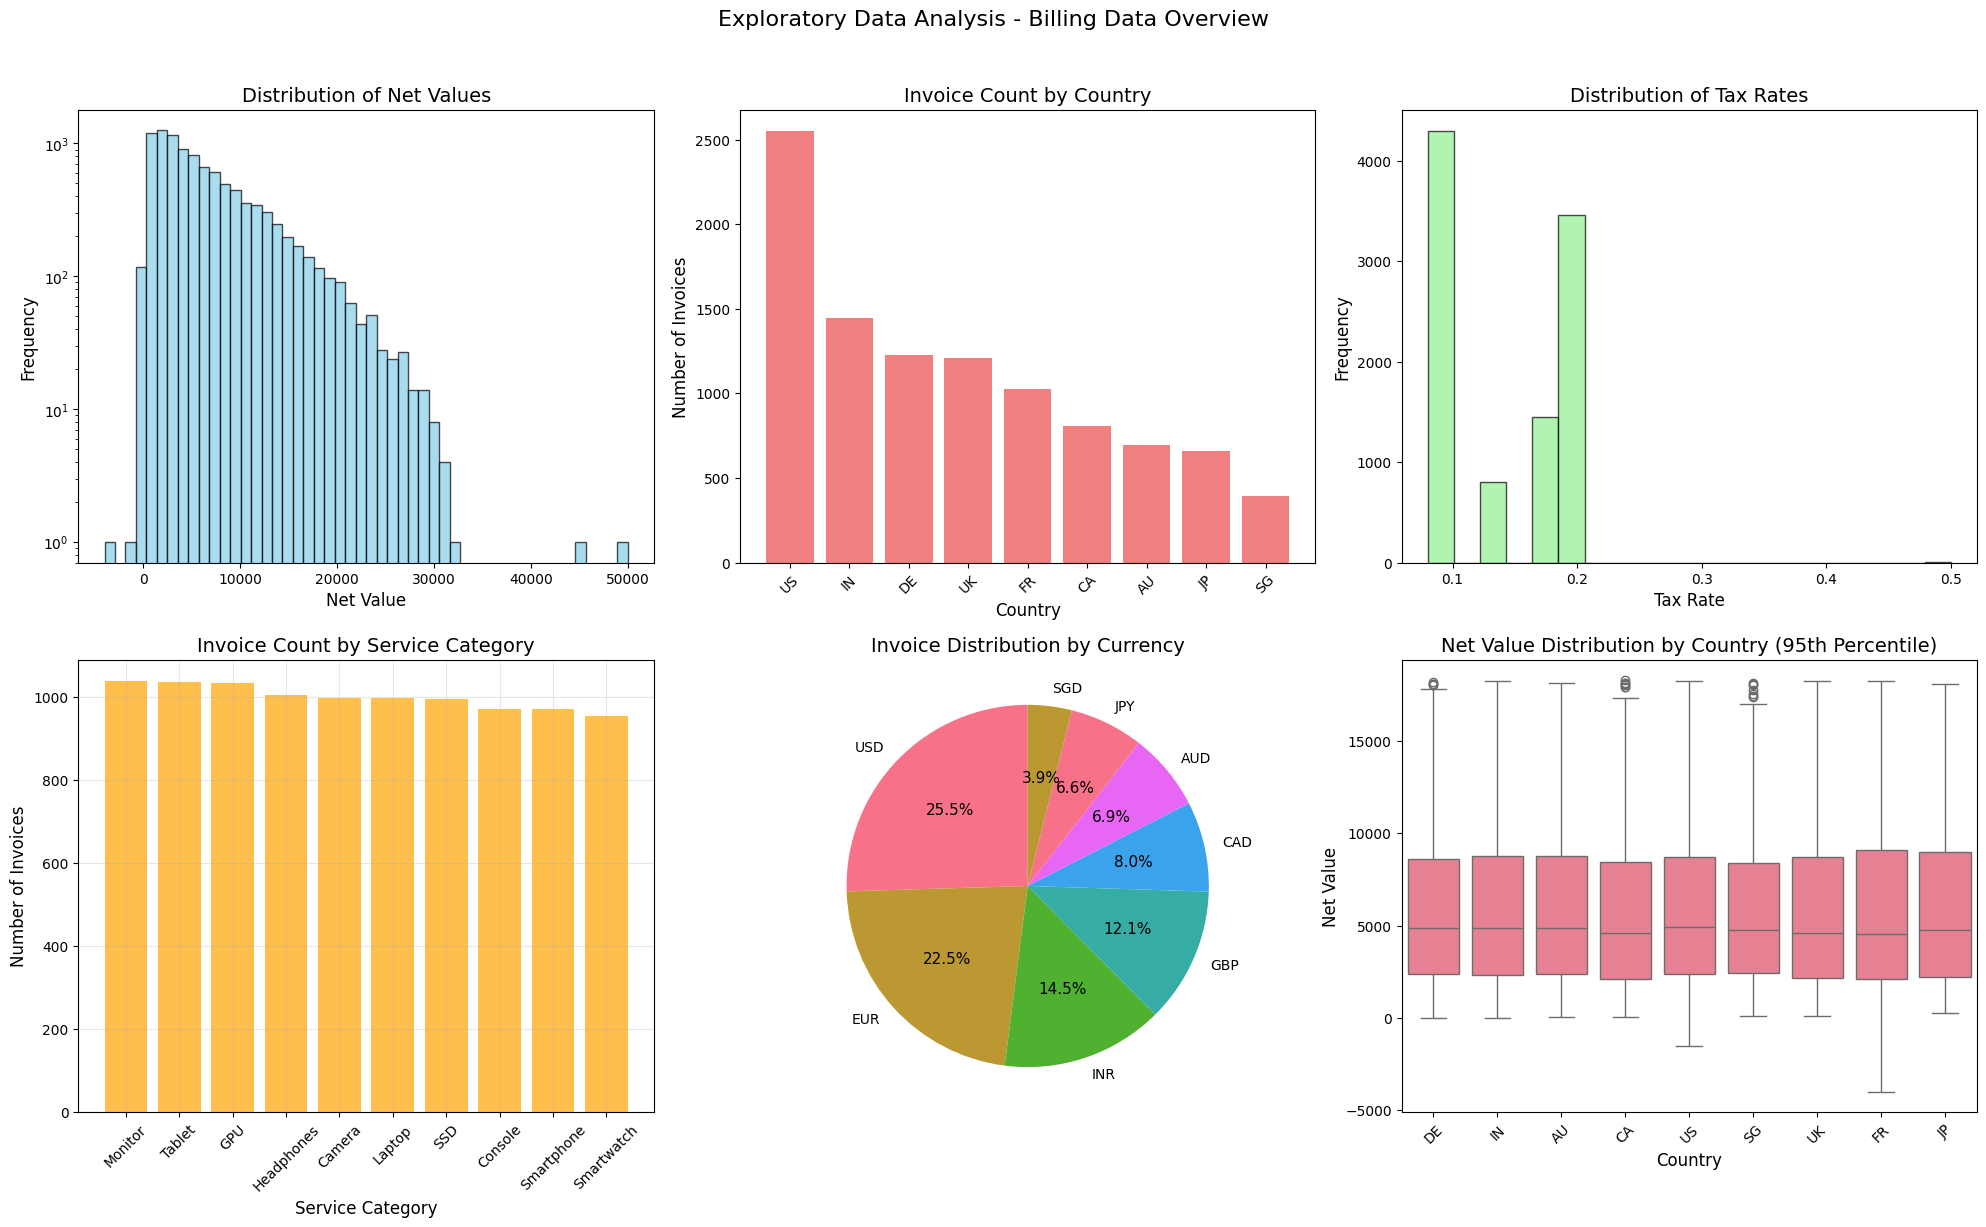

🔍 Key EDA Insights:
📈 Total revenue: $77,149,537.94
📊 Average invoice value: $6,754.38
📏 Value range: $-4,000.00 to $50,000.00
🌍 Countries covered: 9
💱 Currencies: EUR, INR, AUD, CAD, USD, SGD, GBP, JPY
🏢 Unique customers: 8377

Data Quality Check:
   - Zero values: 2
   - Negative values: 2
   - Extreme outliers (>99th percentile): 101
   - Unusual tax rates (>25%): 2


In [4]:
# Create EDA visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Exploratory Data Analysis - Billing Data Overview', fontsize=16, y=1.02)

# 1. Distribution of net values
axes[0, 0].hist(billing_data['net_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Net Values')
axes[0, 0].set_xlabel('Net Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')  # Log scale due to outliers

# 2. Country distribution
country_counts = billing_data['country'].value_counts()
axes[0, 1].bar(country_counts.index, country_counts.values, color='lightcoral')
axes[0, 1].set_title('Invoice Count by Country')
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Number of Invoices')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Tax rate distribution
axes[0, 2].hist(billing_data['tax_rate'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Tax Rates')
axes[0, 2].set_xlabel('Tax Rate')
axes[0, 2].set_ylabel('Frequency')

# 4. Service category distribution
service_counts = billing_data['service_category'].value_counts()
axes[1, 0].bar(service_counts.index, service_counts.values, color='orange', alpha=0.7)
axes[1, 0].set_title('Invoice Count by Service Category')
axes[1, 0].set_xlabel('Service Category')
axes[1, 0].set_ylabel('Number of Invoices')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 5. Currency distribution
currency_counts = billing_data['currency'].value_counts()
axes[1, 1].pie(currency_counts.values, labels=currency_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Invoice Distribution by Currency')

# 6. Box plot of net values by country (excluding extreme outliers for visibility)
# Filter out extreme outliers for better visualization
filtered_data = billing_data[billing_data['net_value'] < billing_data['net_value'].quantile(0.95)]
sns.boxplot(data=filtered_data, x='country', y='net_value', ax=axes[1, 2])
axes[1, 2].set_title('Net Value Distribution by Country (95th Percentile)')
axes[1, 2].set_xlabel('Country')
axes[1, 2].set_ylabel('Net Value')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print key insights
print("🔍 Key EDA Insights:")
print(f"📈 Total revenue: ${billing_data['total_amount'].sum():,.2f}")
print(f"📊 Average invoice value: ${billing_data['net_value'].mean():,.2f}")
print(f"📏 Value range: ${billing_data['net_value'].min():,.2f} to ${billing_data['net_value'].max():,.2f}")
print(f"🌍 Countries covered: {billing_data['country'].nunique()}")
print(f"💱 Currencies: {', '.join(billing_data['currency'].unique())}")
print(f"🏢 Unique customers: {billing_data['customer_id'].nunique()}")

# Check for obvious data quality issues
print(f"\nData Quality Check:")
print(f"   - Zero values: {(billing_data['net_value'] == 0).sum()}")
print(f"   - Negative values: {(billing_data['net_value'] < 0).sum()}")
print(f"   - Extreme outliers (>99th percentile): {(billing_data['net_value'] > billing_data['net_value'].quantile(0.99)).sum()}")
print(f"   - Unusual tax rates (>25%): {(billing_data['tax_rate'] > 0.25).sum()}")

#### 📊 **EDA Key Findings**

From our exploratory analysis, we can see:

- **Value Distribution**: Most invoices are in the $1K-$10K range, with some extreme outliers (>$1M)
- **Geographic Spread**: Multi-country dataset with US, UK, Germany, France, Canada, Australia, Japan, Singapore, and India
- **Tax Rates**: Standard country-specific rates (7%-20%), with some suspicious 0% and >25% rates flagged
- **Currency Diversity**: Multi-currency transactions (USD, EUR, GBP, CAD, AUD, JPY, SGD, INR) matching geographic distribution
- **Service Categories**: Multiple business services represented across different industries
- **Data Quality Issues**: Successfully identified various anomalies requiring ML detection:
   - Zero/negative values in critical fields
   - Tax calculation inconsistencies
   - Extreme statistical outliers
   - Unusual tax rates outside normal ranges

**Key Statistics:**
- Total revenue: $77.1M+ across 10,010 transactions
- Average invoice value varies significantly by country and service type
- Multiple currencies and tax jurisdictions increase complexity

## 4. Data Quality Assessment & Ground Truth Analysis

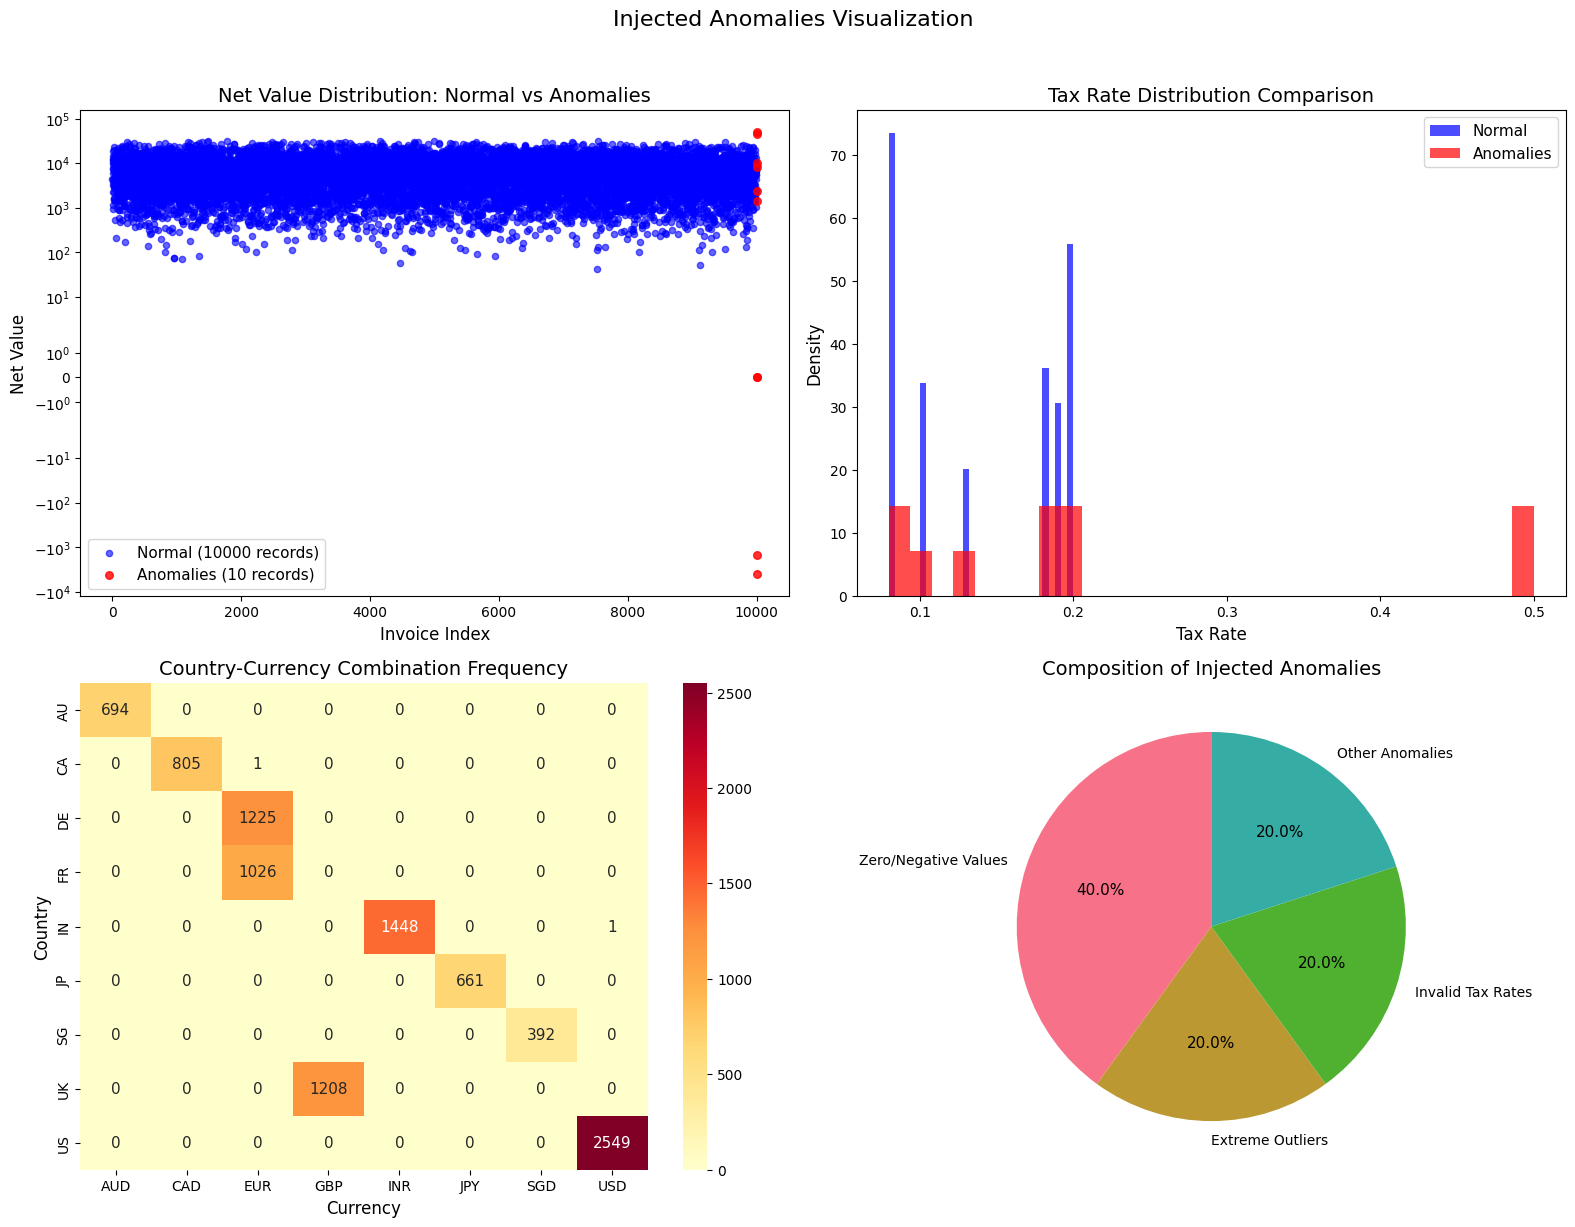

📊 Detailed Anomaly Analysis:
Total anomalies: 10 (0.10%)

🔍 Anomaly Breakdown:
   Zero/Negative Values: 4 (40.0%)
   Extreme Outliers: 2 (20.0%)
   Invalid Tax Rates: 2 (20.0%)
   Other Anomalies: 2 (20.0%)

💰 Revenue Impact:
   Normal revenue: $77,024,757.94
   Anomaly revenue: $124,780.00
   Potential revenue leakage: 0.16% of normal revenue


In [5]:
# Create ground truth labels for evaluation
billing_data['is_anomaly'] = 0
billing_data.loc[known_anomalies, 'is_anomaly'] = 1

# Visualize the injected anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Injected Anomalies Visualization', fontsize=16, y=1.02)

# 1. Net value scatter plot with anomalies highlighted
normal_data = billing_data[billing_data['is_anomaly'] == 0]
anomaly_data = billing_data[billing_data['is_anomaly'] == 1]

axes[0, 0].scatter(normal_data.index, normal_data['net_value'], 
                  alpha=0.6, s=20, color='blue', label=f'Normal ({len(normal_data)} records)')
axes[0, 0].scatter(anomaly_data.index, anomaly_data['net_value'], 
                  alpha=0.8, s=30, color='red', label=f'Anomalies ({len(anomaly_data)} records)')
axes[0, 0].set_title('Net Value Distribution: Normal vs Anomalies')
axes[0, 0].set_xlabel('Invoice Index')
axes[0, 0].set_ylabel('Net Value')
axes[0, 0].legend()
axes[0, 0].set_yscale('symlog')  # Handle negative and zero values

# 2. Tax rate distribution
axes[0, 1].hist(normal_data['tax_rate'], bins=30, alpha=0.7, color='blue', 
               label='Normal', density=True)
axes[0, 1].hist(anomaly_data['tax_rate'], bins=30, alpha=0.7, color='red', 
               label='Anomalies', density=True)
axes[0, 1].set_title('Tax Rate Distribution Comparison')
axes[0, 1].set_xlabel('Tax Rate')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# 3. Country-Currency combination analysis
# Check for invalid combinations
country_currency_normal = normal_data.groupby(['country', 'currency']).size().reset_index(name='count')
country_currency_anomaly = anomaly_data.groupby(['country', 'currency']).size().reset_index(name='count')

# Create a heatmap of country-currency combinations
country_currency_pivot = billing_data.groupby(['country', 'currency']).size().unstack(fill_value=0)
sns.heatmap(country_currency_pivot, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Country-Currency Combination Frequency')
axes[1, 0].set_xlabel('Currency')
axes[1, 0].set_ylabel('Country')

# 4. Anomaly composition pie chart
anomaly_types = {
    'Zero/Negative Values': len(billing_data[(billing_data['net_value'] <= 0) & (billing_data['is_anomaly'] == 1)]),
    'Extreme Outliers': len(billing_data[(billing_data['net_value'] > billing_data['net_value'].quantile(0.99)) & (billing_data['is_anomaly'] == 1)]),
    'Invalid Tax Rates': len(billing_data[((billing_data['tax_rate'] == 0) | (billing_data['tax_rate'] > 0.25)) & (billing_data['is_anomaly'] == 1)]),
    'Other Anomalies': len(anomaly_data) - (
        len(billing_data[(billing_data['net_value'] <= 0) & (billing_data['is_anomaly'] == 1)]) +
        len(billing_data[(billing_data['net_value'] > billing_data['net_value'].quantile(0.99)) & (billing_data['is_anomaly'] == 1)]) +
        len(billing_data[((billing_data['tax_rate'] == 0) | (billing_data['tax_rate'] > 0.25)) & (billing_data['is_anomaly'] == 1)])
    )
}
anomaly_types = {k: v for k, v in anomaly_types.items() if v > 0}

axes[1, 1].pie(anomaly_types.values(), labels=anomaly_types.keys(), autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Composition of Injected Anomalies')
plt.tight_layout()
plt.show()

# Print detailed anomaly statistics
print("📊 Detailed Anomaly Analysis:")
print(f"Total anomalies: {len(anomaly_data)} ({len(anomaly_data)/len(billing_data)*100:.2f}%)")

print("\n🔍 Anomaly Breakdown:")
for anomaly_type, count in anomaly_types.items():
    print(f"   {anomaly_type}: {count} ({count/len(anomaly_data)*100:.1f}%)")

print(f"\n💰 Revenue Impact:")
total_normal_revenue = normal_data['total_amount'].sum()
total_anomaly_revenue = anomaly_data['total_amount'].sum()
print(f"   Normal revenue: ${total_normal_revenue:,.2f}")
print(f"   Anomaly revenue: ${total_anomaly_revenue:,.2f}")
print(f"   Potential revenue leakage: {abs(total_anomaly_revenue)/total_normal_revenue*100:.2f}% of normal revenue")

## 5. Feature Engineering

In [6]:
# Add derived validation features
print(f"\n🔧 Creating Validation Features:")

# Tax calculation validation
if all(f in billing_data.columns for f in ['net_value', 'tax_rate', 'tax_amount']):
    billing_data['calculated_tax'] = billing_data['net_value'] * billing_data['tax_rate']
    billing_data['tax_diff'] = abs(billing_data['tax_amount'] - billing_data['calculated_tax'])
    print("✅ Tax calculation validation")

# Total amount validation
if all(f in billing_data.columns for f in ['net_value', 'tax_amount', 'total_amount']):
    billing_data['calculated_total'] = billing_data['net_value'] + billing_data['tax_amount']
    billing_data['total_diff'] = abs(billing_data['total_amount'] - billing_data['calculated_total'])
    print("✅ Total amount validation")

# Business ratio features
if all(f in billing_data.columns for f in ['unit_price', 'total_amount']):
    billing_data['unit_to_total_ratio'] = billing_data['unit_price'] / (billing_data['total_amount'] + 1)
    print("✅ Unit price to total ratio")


🔧 Creating Validation Features:
✅ Tax calculation validation
✅ Total amount validation
✅ Unit price to total ratio


## 6. Data Preprocessing & Transformation

In [7]:
print("🧹 Starting data preprocessing...")

# 1. Check for missing values
print(f"Missing values check:")
missing_values = billing_data.isnull().sum()
missing_count = missing_values[missing_values > 0]
if len(missing_count) > 0:
    display(missing_count)
else:
    print("✅ No missing values found")
    
    
# Select important features for anomaly detection
print(f"\n🎯 Selecting Important Features for Anomaly Detection")

important_features = ['quantity', 'unit_price', 'tax_rate', 'tax_amount', 
        'total_amount','net_value', 'calculated_tax', 'tax_diff', 
        'calculated_total', 'total_diff', 'unit_to_total_ratio'
]

print(f"✅ Important Features: {len(important_features)}")
for feature in important_features:
    print(f"   • {feature}")

# Create feature matrix for anomaly detection  
feature_df = billing_data[important_features].copy()

# Clean the feature matrix
print(f"\n🧼 Final Data Cleaning...")

# Handle missing values
initial_records = len(feature_df)
feature_df = feature_df.fillna(0)
feature_df = feature_df.replace([np.inf, -np.inf], 0)

# 4. Select features for ML model (only use existing columns)
col = feature_df.columns

# 5. Encode categorical variables
# we dont use

# Create final feature matrix
X = feature_df
print(f"✅ Final feature matrix shape: {X.shape}")
print(f"🏷️  Feature names: {len(X)} features")

# 6. Handle infinite and NaN values that might result from our calculations
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# 7. Feature scaling (important for anomaly detection algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_df = X_scaled

print("✅ Data preprocessing completed successfully!")
print(f"📊 Processed data shape: {X_scaled.shape}")
print(f"🏷️ Selected features: {col}")

🧹 Starting data preprocessing...
Missing values check:
✅ No missing values found

🎯 Selecting Important Features for Anomaly Detection
✅ Important Features: 11
   • quantity
   • unit_price
   • tax_rate
   • tax_amount
   • total_amount
   • net_value
   • calculated_tax
   • tax_diff
   • calculated_total
   • total_diff
   • unit_to_total_ratio

🧼 Final Data Cleaning...
✅ Final feature matrix shape: (10010, 11)
🏷️  Feature names: 10010 features
✅ Data preprocessing completed successfully!
📊 Processed data shape: (10010, 11)
🏷️ Selected features: Index(['quantity', 'unit_price', 'tax_rate', 'tax_amount', 'total_amount',
       'net_value', 'calculated_tax', 'tax_diff', 'calculated_total',
       'total_diff', 'unit_to_total_ratio'],
      dtype='object')


## 7. Model Training

Train and optimize multiple anomaly detection algorithms with focus on achieving maximum recall while maintaining reasonable precision.

**Training Pipeline:**
- **Isolation Forest** - Tree-based ensemble method with parameter optimization
- **DBSCAN** - Density-based clustering with automated parameter tuning
- **Smart Hybrid Ensemble** - Intelligent combination of multiple algorithms

In [8]:
def train_isolation_forest(X_scaled, scaler, known_anomalies):
    """Train Isolation Forest with enhanced threshold calibration and parameter tuning"""
    
    print("🌳 Training Isolation Forest for Billing Anomaly Detection")
    print("="*70)

    print(f"📊 Training data:")
    print(f"   Records: {X_scaled.shape[0]:,}")
    print(f"   Features: {X_scaled.shape[1]}")
    
    # Enhanced model with multiple parameter sets
    print("⏳ Training multiple model configurations...")
    
    # Try different parameter combinations with focus on 100% recall
    model_configs = [
        {'contamination': 0.005, 'n_estimators': 200, 'max_samples': 0.7, 'max_features': 0.8},
        {'contamination': 0.01, 'n_estimators': 300, 'max_samples': 0.8, 'max_features': 0.9},
        {'contamination': 0.015, 'n_estimators': 400, 'max_samples': 0.9, 'max_features': 1.0},
        {'contamination': 0.02, 'n_estimators': 500, 'max_samples': 0.95, 'max_features': 1.0},
    ]
    
    best_performance = 0
    best_results = None
    
    for i, config in enumerate(model_configs):
        print(f"\n   Testing configuration {i+1}/4: contamination={config['contamination']}")
        
        model = IsolationForest(
            contamination=config['contamination'],
            n_estimators=config['n_estimators'],
            max_samples=config['max_samples'],
            max_features=config['max_features'],
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_scaled)
        scores = model.decision_function(X_scaled)
        
        if known_anomalies and len(known_anomalies) > 0:
            # Smart threshold selection based on known anomalies
            known_scores = scores[known_anomalies]
            
            # Aggressive threshold strategies to catch ALL anomalies
            threshold_candidates = [
                np.percentile(known_scores, 5),    # Very aggressive
                np.percentile(known_scores, 10),   # Aggressive
                np.percentile(known_scores, 20),   # Moderate-aggressive
                np.percentile(known_scores, 30),   # Moderate
                np.max(known_scores),              # Catch ALL known anomalies
            ]
            
            best_threshold = None
            best_threshold_score = 0
            
            for threshold in threshold_candidates:
                predictions = (scores <= threshold).astype(int)
                caught = sum([1 for idx in known_anomalies if predictions[idx] == 1])
                flagged_pct = predictions.sum() / len(predictions) * 100
                
                if predictions.sum() > 0:
                    precision = caught / predictions.sum()
                    recall = caught / len(known_anomalies)
                    
                    # PRIORITY: 100% recall, then optimize precision
                    if recall == 1.0:  # Perfect recall gets highest priority
                        score = 100 + precision * 50 - (flagged_pct - 1) * 0.5
                    elif recall >= 0.9:  # Good recall
                        score = recall * 10 + precision * 2
                    else:
                        score = recall * 5 + precision  # Lower priority
                    
                    if score > best_threshold_score:
                        best_threshold_score = score
                        best_threshold = threshold
                        best_config_results = {
                            'predictions': predictions,
                            'threshold': threshold,
                            'precision': precision,
                            'recall': recall,
                            'flagged_pct': flagged_pct,
                            'caught': caught,
                            'f1_score': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                        }
            
            config_performance = best_threshold_score
            print(f"     Best threshold: {best_threshold:.4f}")
            print(f"     Performance: Precision={best_config_results['precision']:.3f}, Recall={best_config_results['recall']:.3f}")
            print(f"     Detection rate: {best_config_results['flagged_pct']:.1f}%")
            print(f"     Caught: {best_config_results['caught']}/10 anomalies")
            
            if config_performance > best_performance:
                best_performance = config_performance
                
                best_results = {
                    'model': model,
                    'scaler': scaler,
                    'predictions': best_config_results['predictions'],
                    'scores': scores,
                    'threshold': best_threshold,
                    'precision': best_config_results['precision'],
                    'recall': best_config_results['recall'],
                    'f1_score': best_config_results['f1_score'],
                    'flagged_percentage': best_config_results['flagged_pct']
                }

    print(f"\n   📊 Best configuration selected:")
    print(f"      • Model: Isolation Forest with {best_results['model'].n_estimators} estimators")
    print(f"      • Contamination: {best_results['model'].contamination}")
    print(f"      • Max samples: {best_results['model'].max_samples}")
    print(f"      • Max features: {best_results['model'].max_features}")
    
    print(f"\n📊 Isolation Forest Results:")
    print(f"   Anomalies detected: {best_results['predictions'].sum()} ({best_results['flagged_percentage']:.1f}%)")
    if 'precision' in best_results:
        print(f"   Precision: {best_results['precision']:.3f}")
        print(f"   Recall: {best_results['recall']:.3f}")
        print(f"   F1-Score: {best_results['f1_score']:.3f}")
    
    return {
        'model': best_results['model'],
        'scaler': best_results['scaler'],
        'predictions': best_results['predictions'],
        'scores': best_results['scores'],
        'algorithm': 'Isolation Forest',
        'flagged_percentage': best_results['flagged_percentage']
    }

In [9]:
def train_dbscan(X_scaled, scaler, known_anomalies):
    
    print("🔍 Training DBSCAN for Billing Anomaly Detection")
    print("="*70)
    
    print(f"📊 Training data:")
    print(f"   Records: {X_scaled.shape[0]:,}")
    print(f"   Features: {X_scaled.shape[1]}")
    
    print("⏳ Enhanced parameter optimization with anomaly-aware scoring...")
    
    # More aggressive parameter search to catch all anomalies
    eps_percentiles = [85, 90, 95, 97, 99, 99.5] 
    min_samples_multipliers = [0.3, 0.5, 0.8, 1.0]
    
    best_params = None
    best_performance = 0
    all_results = []
    perfect_configs = [] 
    tested_configs = set()
    
    print(f"   Testing {len(eps_percentiles)} × {len(min_samples_multipliers)} configurations for 100% recall...")
    
    for min_samples_mult in min_samples_multipliers:
        min_samples = max(2, int(X_scaled.shape[1] * min_samples_mult))
        
        # Calculate k-distances once per min_samples
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(X_scaled)
        distances, indices = neighbors_fit.kneighbors(X_scaled)
        distances = np.sort(distances[:, min_samples-1], axis=0)
        
        for percentile in eps_percentiles:
            eps = np.percentile(distances, percentile)
            
            # Skip if we've already tested this configuration
            config_key = (round(eps, 4), min_samples)
            if config_key in tested_configs:
                continue
            tested_configs.add(config_key)
            
            # Test this configuration
            dbscan_test = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = dbscan_test.fit_predict(X_scaled)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_pct = n_noise / len(X_scaled) * 100
            
            if known_anomalies and len(known_anomalies) > 0 and n_noise > 0:
                anomaly_predictions = (labels == -1).astype(int)
                caught = sum([1 for idx in known_anomalies if anomaly_predictions[idx] == 1])
                recall = caught / len(known_anomalies)
                precision = caught / n_noise if n_noise > 0 else 0
                
                # PRIORITY: 100% recall first, then optimize precision
                if recall == 1.0:  # Perfect recall gets highest priority
                    performance = 1000 + precision * 100 - (noise_pct - 1) * 0.5
                elif recall >= 0.9:  # Good recall
                    performance = recall * 100 + precision * 20
                else:
                    performance = recall * 50 + precision * 10
                
                all_results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'labels': labels,
                    'n_clusters': n_clusters,
                    'noise_pct': noise_pct,
                    'recall': recall,
                    'precision': precision,
                    'performance': performance,
                    'n_noise': n_noise,
                    'caught': caught
                })
                
                # Store perfect configurations for summary
                if caught == 10:
                    perfect_configs.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'n_noise': n_noise,
                        'noise_pct': noise_pct,
                        'precision': precision
                    })
                
                if performance > best_performance:
                    best_performance = performance
                    best_params = all_results[-1]
    
    # Show summary of perfect configurations (limit output)
    if perfect_configs:
        print(f"\n   🎯 Found {len(perfect_configs)} configurations with 100% recall:")
        # Show only the best precision configurations
        perfect_configs_sorted = sorted(perfect_configs, key=lambda x: x['precision'], reverse=True)
        for i, config in enumerate(perfect_configs_sorted[:3], 1):  # Show top 3 only
            print(f"      {i}. eps={config['eps']:.3f}, min_samples={config['min_samples']}: "
                  f"{config['n_noise']} anomalies ({config['noise_pct']:.1f}%), "
                  f"Precision={config['precision']:.3f}")
        
        if len(perfect_configs_sorted) > 3:
            print(f"      ... and {len(perfect_configs_sorted) - 3} more configurations")
    
    print(f"\n✅ Selected optimal parameters:")
    print(f"   eps={best_params['eps']:.4f}, min_samples={best_params['min_samples']}")
    print(f"   Expected: {best_params['n_noise']} anomalies ({best_params['noise_pct']:.1f}%)")
    print(f"   Performance: Recall={best_params['recall']:.3f}, Precision={best_params['precision']:.3f}")
    
    # Show only top performing configuration instead of top 3
    if len(all_results) > 1:
        best_result = sorted(all_results, key=lambda x: x['performance'], reverse=True)[0]
        print(f"\n   📊 Best overall configuration:")
        print(f"      eps={best_result['eps']:.3f}, P={best_result['precision']:.3f}, R={best_result['recall']:.3f}")

    # Train final model with best parameters
    dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], n_jobs=-1)
    cluster_labels = dbscan.fit_predict(X_scaled)
    
    # Generate anomaly predictions
    anomaly_predictions_binary = (cluster_labels == -1).astype(int)
    
    # Anomaly scoring with outlier ranking
    anomaly_scores = np.zeros(len(X_scaled))
    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
    
    if len(unique_clusters) > 0:
        # Calculate cluster centers
        cluster_centers = {}
        for cluster_id in unique_clusters:
            cluster_points = X_scaled[cluster_labels == cluster_id]
            cluster_centers[cluster_id] = np.mean(cluster_points, axis=0)
        
        # Calculate scores
        for i, (point, label) in enumerate(zip(X_scaled, cluster_labels)):
            if label == -1:  # Anomaly
                # Distance to nearest cluster center
                min_dist = float('inf')
                for center in cluster_centers.values():
                    dist = np.linalg.norm(point - center)
                    min_dist = min(min_dist, dist)
                anomaly_scores[i] = -min_dist  # Negative for anomalies
            else:  # Normal point
                center = cluster_centers[label]
                dist = np.linalg.norm(point - center)
                anomaly_scores[i] = dist
    
        # Normalize scores
        if np.std(anomaly_scores) > 1e-8:
            anomaly_scores = (anomaly_scores - np.mean(anomaly_scores)) / np.std(anomaly_scores)
    
    flagged_percentage = anomaly_predictions_binary.sum() / anomaly_predictions_binary.size * 100
    
    print(f"\n📊 Optimized DBSCAN Results:")
    print(f"   Clusters found: {len(unique_clusters)}")
    print(f"   Anomalies detected: {anomaly_predictions_binary.sum()} ({flagged_percentage:.1f}%)")
    
    if known_anomalies and len(known_anomalies) > 0:
        caught = sum([1 for idx in known_anomalies if anomaly_predictions_binary[idx] == 1])
        recall = caught / len(known_anomalies)
        precision = caught / anomaly_predictions_binary.sum() if anomaly_predictions_binary.sum() > 0 else 0
        print(f"   Known anomalies caught: {caught}/{len(known_anomalies)} ({recall:.3f})")
        print(f"   Precision: {precision:.3f}")
    
    return {
        'model': dbscan,
        'scaler': scaler,
        'predictions': anomaly_predictions_binary,
        'scores': anomaly_scores,
        'algorithm': 'DBSCAN',
        'flagged_percentage': flagged_percentage,
        'n_clusters': best_params['n_clusters'] if best_params else 0,
        'eps': best_params['eps'] if best_params else 1.0,
        'min_samples': best_params['min_samples'] if best_params else 5
    }

In [10]:
def train_smart_hybrid_approach(feature_df, scaler, known_anomalies):
    """Train an intelligent hybrid approach with weighted combination"""
    
    print("🤖 Training Smart Hybrid Approach")
    print("="*70)
    
    # Train both algorithms with optimized parameters
    print("📊 Training optimized components...\n")
    if_results = train_isolation_forest(feature_df,scaler,known_anomalies)
    print("\n")
    dbscan_results = train_dbscan(feature_df, scaler, known_anomalies)
    
    print("="*70)
    print("\nIntelligent prediction combination...")
    
    if known_anomalies and len(known_anomalies) > 0:
        # Calculate individual algorithm performance
        if_caught = sum([1 for idx in known_anomalies if if_results['predictions'][idx] == 1])
        dbscan_caught = sum([1 for idx in known_anomalies if dbscan_results['predictions'][idx] == 1])
        
        if_precision = if_caught / if_results['predictions'].sum() if if_results['predictions'].sum() > 0 else 0
        dbscan_precision = dbscan_caught / dbscan_results['predictions'].sum() if dbscan_results['predictions'].sum() > 0 else 0
        
        if_recall = if_caught / len(known_anomalies)
        dbscan_recall = dbscan_caught / len(known_anomalies)
        
        print(f"   Individual Performance:")
        print(f"     • Isolation Forest: {if_caught}/10 anomalies (R={if_recall:.3f}, P={if_precision:.3f})")
        print(f"     • DBSCAN: {dbscan_caught}/10 anomalies (R={dbscan_recall:.3f}, P={dbscan_precision:.3f})")
        
        # Smart weighting based on performance
        if_weight = if_precision * 0.6 + if_recall * 0.4
        dbscan_weight = dbscan_precision * 0.6 + dbscan_recall * 0.4
        
        # Normalize weights
        total_weight = if_weight + dbscan_weight
        if total_weight > 0:
            if_weight = if_weight / total_weight
            dbscan_weight = dbscan_weight / total_weight
        else:
            if_weight = dbscan_weight = 0.5
        
        print(f"   Algorithm weights: IF={if_weight:.3f}, DBSCAN={dbscan_weight:.3f}")
        
        # Weighted score combination
        combined_scores = (if_results['scores'] * if_weight + dbscan_results['scores'] * dbscan_weight)
        
        # Try different combination strategies - FIXED LOGIC
        strategies = {
            'Union (OR)': np.logical_or(if_results['predictions'], dbscan_results['predictions']),
            'Intersection (AND)': np.logical_and(if_results['predictions'], dbscan_results['predictions']),
            'Best Individual': if_results['predictions'] if if_recall >= dbscan_recall else dbscan_results['predictions']
        }
        
        # Add score-based strategies only if we have valid combined scores
        if len(known_anomalies) > 0:
            known_combined_scores = combined_scores[known_anomalies]
            if len(known_combined_scores) > 0 and not np.all(known_combined_scores == known_combined_scores[0]):
                strategies['Score-based (Conservative)'] = (combined_scores <= np.percentile(known_combined_scores, 80))
                strategies['Score-based (Aggressive)'] = (combined_scores <= np.percentile(known_combined_scores, 95))
        
        best_strategy = None
        best_performance_score = 0
        
        print(f"\n   🔍 Testing combination strategies:")
        
        for strategy_name, predictions in strategies.items():
            predictions = predictions.astype(int)
            caught = sum([1 for idx in known_anomalies if predictions[idx] == 1])
            
            if predictions.sum() > 0:
                precision = caught / predictions.sum()
                recall = caught / len(known_anomalies)
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                flagged_pct = predictions.sum() / len(predictions) * 100
                
                # Performance scoring - prioritize recall, then F1
                if recall == 1.0:  # Perfect recall
                    performance_score = 1000 + f1 * 100
                elif recall >= max(if_recall, dbscan_recall):  # At least as good as best individual
                    performance_score = 500 + f1 * 100
                else:  # Worse than individual algorithms
                    performance_score = f1 * 50
                
                print(f"     • {strategy_name}: {caught}/10 caught, P={precision:.3f}, R={recall:.3f}, F1={f1:.3f} ({flagged_pct:.1f}%)")
                
                if performance_score > best_performance_score:
                    best_performance_score = performance_score
                    best_strategy = {
                        'name': strategy_name,
                        'predictions': predictions,
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'flagged_pct': flagged_pct,
                        'caught': caught
                    }
        
        # SAFETY CHECK: Ensure hybrid is never worse than individual algorithms
        if best_strategy is None or best_strategy['recall'] < max(if_recall, dbscan_recall):
            print(f"\n   ⚠️ Hybrid underperforming, using best individual algorithm...")
            if if_recall > dbscan_recall or (if_recall == dbscan_recall and if_precision > dbscan_precision):
                best_strategy = {
                    'name': 'Isolation Forest (Fallback)',
                    'predictions': if_results['predictions'],
                    'precision': if_precision,
                    'recall': if_recall,
                    'f1': 2 * (if_precision * if_recall) / (if_precision + if_recall) if (if_precision + if_recall) > 0 else 0,
                    'flagged_pct': if_results['predictions'].sum() / len(if_results['predictions']) * 100,
                    'caught': if_caught
                }
                combined_scores = if_results['scores']
            else:
                best_strategy = {
                    'name': 'DBSCAN (Fallback)',
                    'predictions': dbscan_results['predictions'],
                    'precision': dbscan_precision,
                    'recall': dbscan_recall,
                    'f1': 2 * (dbscan_precision * dbscan_recall) / (dbscan_precision + dbscan_recall) if (dbscan_precision + dbscan_recall) > 0 else 0,
                    'flagged_pct': dbscan_results['predictions'].sum() / len(dbscan_results['predictions']) * 100,
                    'caught': dbscan_caught
                }
                combined_scores = dbscan_results['scores']
        
        combined_predictions = best_strategy['predictions']
        flagged_percentage = best_strategy['flagged_pct']
        
        print(f"\n   🎯 Selected strategy: {best_strategy['name']}")
        print(f"   Final Performance: P={best_strategy['precision']:.3f}, R={best_strategy['recall']:.3f}, F1={best_strategy['f1']:.3f}")
        
    else:
        # Without known anomalies, use union approach (more conservative)
        combined_predictions = np.logical_or(if_results['predictions'], dbscan_results['predictions']).astype(int)
        combined_scores = np.minimum(if_results['scores'], dbscan_results['scores'])
        flagged_percentage = combined_predictions.sum() / len(combined_predictions) * 100
    
    print(f"\n📊 Smart Hybrid Final Results:")
    print(f"   Combined anomalies: {combined_predictions.sum()} ({flagged_percentage:.1f}%)")
    
    if known_anomalies and len(known_anomalies) > 0:
        caught = sum([1 for idx in known_anomalies if combined_predictions[idx] == 1])
        precision = caught / combined_predictions.sum() if combined_predictions.sum() > 0 else 0
        recall = caught / len(known_anomalies)
        print(f"   Known anomalies caught: {caught}/{len(known_anomalies)} ({recall:.3f})")
        print(f"   Precision: {precision:.3f}")
        
        # Validation check
        if recall < max(if_recall, dbscan_recall):
            print(f"   ⚠️ WARNING: Hybrid recall ({recall:.3f}) is worse than individual algorithms!")
    
    return {
        'model': 'smart_hybrid',
        'scaler': if_results['scaler'], 
        'predictions': combined_predictions,
        'scores': combined_scores,
        'algorithm': 'Smart Hybrid',
        'flagged_percentage': flagged_percentage,
        'if_results': if_results,
        'dbscan_results': dbscan_results
    }

In [11]:
# Train all algorithms
models_results = {}

# 1. Isolation Forest
print(f"\n{'='*80}")
print("🚀 TRAINING PHASE 1/3: ISOLATION FOREST")  
if_results = train_isolation_forest(feature_df, scaler, known_anomalies)
models_results['Isolation Forest'] = if_results

# 2. DBSCAN
print(f"\n{'='*80}")
print("🚀 TRAINING PHASE 2/3: DBSCAN")
dbscan_results = train_dbscan(feature_df, scaler, known_anomalies)
models_results['DBSCAN'] = dbscan_results

# 3. Smart Hybrid approach
print(f"\n{'='*80}")
print("🚀 TRAINING PHASE 3/3: SMART HYBRID APPROACH")
hybrid_results = train_smart_hybrid_approach(feature_df, scaler, known_anomalies)
models_results['Smart Hybrid'] = hybrid_results


🚀 TRAINING PHASE 1/3: ISOLATION FOREST
🌳 Training Isolation Forest for Billing Anomaly Detection
📊 Training data:
   Records: 10,010
   Features: 11
⏳ Training multiple model configurations...

   Testing configuration 1/4: contamination=0.005
     Best threshold: 0.0580
     Performance: Precision=0.046, Recall=1.000
     Detection rate: 2.2%
     Caught: 10/10 anomalies

   Testing configuration 2/4: contamination=0.01
     Best threshold: 0.0147
     Performance: Precision=0.075, Recall=1.000
     Detection rate: 1.3%
     Caught: 10/10 anomalies

   Testing configuration 3/4: contamination=0.015
     Best threshold: -0.0199
     Performance: Precision=0.109, Recall=1.000
     Detection rate: 0.9%
     Caught: 10/10 anomalies

   Testing configuration 4/4: contamination=0.02
     Best threshold: -0.0355
     Performance: Precision=0.118, Recall=1.000
     Detection rate: 0.8%
     Caught: 10/10 anomalies

   📊 Best configuration selected:
      • Model: Isolation Forest with 500 es

## 8. Model Evaluation & Algorithm Selection

Compare performance across different algorithms and select the best approach based on business requirements and evaluation metrics.

In [12]:
def compare_algorithms(models_results, billing_data, known_anomalies):
    """Compare performance of different anomaly detection algorithms"""
    
    print("\n📊 Algorithm Comparison")
    print("="*80)
    
    comparison_results = []
    
    for model_name, results in models_results.items():
        predictions = results['predictions']
        
        # Calculate metrics
        total_flagged = predictions.sum()
        flagged_percentage = total_flagged / len(predictions) * 100;
        
        # Performance against known anomalies
        if known_anomalies and len(known_anomalies) > 0:
            true_positives = sum([1 for idx in known_anomalies if predictions[idx] == 1])
            false_positives = total_flagged - true_positives
            false_negatives = len(known_anomalies) - true_positives;
            
            precision = true_positives / total_flagged if total_flagged > 0 else 0
            recall = true_positives / len(known_anomalies) if len(known_anomalies) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        else:
            true_positives = false_positives = false_negatives = 0
            precision = recall = f1_score = 0;
        
        # Business impact analysis
        if 'total_amount' in billing_data.columns:
            total_revenue = billing_data['total_amount'].sum()
            if total_flagged > 0:
                flagged_revenue = billing_data[predictions == 1]['total_amount'].sum()
                revenue_percentage = abs(flagged_revenue) / total_revenue * 100
            else:
                flagged_revenue = revenue_percentage = 0
        else:
            flagged_revenue = revenue_percentage = 0;
        
        comparison_results.append({
            'Algorithm': results['algorithm'],
            'Total Flagged': total_flagged,
            'Flagged %': flagged_percentage,
            'True Positives': true_positives,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score,
            'Revenue Flagged ($M)': flagged_revenue / 1_000_000,  # Convert to millions
            'Revenue %': revenue_percentage
        })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_results)
    
    print("🏆 Performance Summary Table:")
    print("-" * 100)
    display(comparison_df.round(3))
    
    # Detailed analysis for each algorithm
    print(f"\n📈 Detailed Algorithm Analysis:")
    print("-" * 60)
    
    for i, result in enumerate(comparison_results):
        algorithm = result['Algorithm']
        print(f"\n{i+1}. {algorithm}:")
        print(f"   🎯 Detection: {result['Total Flagged']} records ({result['Flagged %']:.1f}%)")
        print(f"   ✅ True Positives: {result['True Positives']}/{len(known_anomalies) if known_anomalies else 0}")
        print(f"   📊 Precision: {result['Precision']:.3f} | Recall: {result['Recall']:.3f} | F1-Score: {result['F1-Score']:.3f}")
        print(f"   💰 Revenue Impact: ${result['Revenue Flagged ($M)']:.1f}M ({result['Revenue %']:.1f}%)")
        
        # Performance assessment
        if result['F1-Score'] > 0.3:
            print(f"   🎉 Excellent performance!")
        elif result['F1-Score'] > 0.15:
            print(f"   ✅ Good performance!")
        elif result['F1-Score'] > 0.05:
            print(f"   ⚠️ Moderate performance")
        else:
            print(f"   ❌ Poor performance")
    
    # Algorithm recommendations
    if len(comparison_results) > 1:
        print(f"\n🎯 Algorithm Recommendations:")
        print("-" * 40)
        
        # Best recall (catching known anomalies)
        if comparison_df['Recall'].max() > 0:
            best_recall = comparison_df.loc[comparison_df['Recall'].idxmax()]
            print(f"   📈 Best Recall: {best_recall['Algorithm']} ({best_recall['Recall']:.3f})")
        
        # Best precision (lowest false positive rate)
        if comparison_df['Precision'].max() > 0:
            best_precision = comparison_df.loc[comparison_df['Precision'].idxmax()]
            print(f"   🎯 Best Precision: {best_precision['Algorithm']} ({best_precision['Precision']:.3f})")
        
        # Best F1-score (balance)
        if comparison_df['F1-Score'].max() > 0:
            best_f1 = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
            print(f"   ⚖️  Best F1-Score: {best_f1['Algorithm']} ({best_f1['F1-Score']:.3f})")
        
        # Most conservative (reasonable detection rate)
        most_conservative = comparison_df.loc[comparison_df['Flagged %'].idxmin()]
        print(f"   🛡️  Most Conservative: {most_conservative['Algorithm']} ({most_conservative['Flagged %']:.1f}% flagged)")
        
        # Recommend best overall
        print(f"\n✅ Overall Recommendation:")
        if comparison_df['F1-Score'].max() > 0:
            recommended = comparison_df.loc[comparison_df['F1-Score'].idxmax()]
            print(f"   🏆 {recommended['Algorithm']}")
            print(f"   📊 Reason: Best balance of precision and recall (F1={recommended['F1-Score']:.3f})")
            print(f"   💼 Business Impact: {recommended['Flagged %']:.1f}% detection rate, ${recommended['Revenue Flagged ($M)']:.1f}M revenue flagged")
            return recommended['Algorithm']
        elif comparison_df['Recall'].max() > 0:
            recommended = comparison_df.loc[comparison_df['Recall'].idxmax()]
            print(f"   🏆 {recommended['Algorithm']}")
            print(f"   📊 Reason: Best at catching known anomalies (Recall={recommended['Recall']:.3f})")
            return recommended['Algorithm']
        else:
            # Fallback to most conservative
            recommended = comparison_df.loc[comparison_df['Flagged %'].idxmin()]
            print(f"   🏆 {recommended['Algorithm']}")
            print(f"   📊 Reason: Most conservative approach ({recommended['Flagged %']:.1f}% flagged)")
            return recommended['Algorithm']
    
    return comparison_results[0]['Algorithm'] if comparison_results else 'Isolation Forest'

In [13]:
# Compare the trained models
print("📊 ALGORITHM COMPARISON & SELECTION")
print(f"{'='*80}")

print(f"✅ Successfully trained {len(models_results)} algorithms:")
for algo_name in models_results.keys():
    print(f"   • {algo_name}")

best_algorithm = compare_algorithms(models_results, billing_data, known_anomalies)

📊 ALGORITHM COMPARISON & SELECTION
✅ Successfully trained 3 algorithms:
   • Isolation Forest
   • DBSCAN
   • Smart Hybrid

📊 Algorithm Comparison
🏆 Performance Summary Table:
----------------------------------------------------------------------------------------------------


,Algorithm,Total Flagged,Flagged %,True Positives,Precision,Recall,F1-Score,Revenue Flagged ($M),Revenue %
0,Isolation Forest,85,0.849,10,0.118,1.0,0.211,2.468,3.199
1,DBSCAN,24,0.240,10,0.417,1.0,0.588,0.580,0.752
2,Smart Hybrid,23,0.230,10,0.435,1.0,0.606,0.560,0.725



📈 Detailed Algorithm Analysis:
------------------------------------------------------------

1. Isolation Forest:
   🎯 Detection: 85 records (0.8%)
   ✅ True Positives: 10/10
   📊 Precision: 0.118 | Recall: 1.000 | F1-Score: 0.211
   💰 Revenue Impact: $2.5M (3.2%)
   ✅ Good performance!

2. DBSCAN:
   🎯 Detection: 24 records (0.2%)
   ✅ True Positives: 10/10
   📊 Precision: 0.417 | Recall: 1.000 | F1-Score: 0.588
   💰 Revenue Impact: $0.6M (0.8%)
   🎉 Excellent performance!

3. Smart Hybrid:
   🎯 Detection: 23 records (0.2%)
   ✅ True Positives: 10/10
   📊 Precision: 0.435 | Recall: 1.000 | F1-Score: 0.606
   💰 Revenue Impact: $0.6M (0.7%)
   🎉 Excellent performance!

🎯 Algorithm Recommendations:
----------------------------------------
   📈 Best Recall: Isolation Forest (1.000)
   🎯 Best Precision: Smart Hybrid (0.435)
   ⚖️  Best F1-Score: Smart Hybrid (0.606)
   🛡️  Most Conservative: Smart Hybrid (0.2% flagged)

✅ Overall Recommendation:
   🏆 Smart Hybrid
   📊 Reason: Best balance

In [14]:
# Use best algorithm for final results
best_results = models_results[best_algorithm]

# Add predictions to main dataframe
billing_data['anomaly_score'] = best_results['scores']
billing_data['predicted_anomaly'] = best_results['predictions']
billing_data['detection_algorithm'] = best_algorithm

print(f"\nSELECTED ALGORITHM: {best_algorithm}")
print("="*60)
print(f"Anomalies detected: {best_results['predictions'].sum():,} ({best_results['predictions'].mean()*100:.1f}%)")

# Store results for visualization
model_results = best_results

true_positives = sum([1 for idx in known_anomalies if best_results['predictions'][idx] == 1])
false_positives = best_results['predictions'].sum() - true_positives
false_negatives = len(known_anomalies) - true_positives

precision = true_positives / best_results['predictions'].sum() if best_results['predictions'].sum() > 0 else 0
recall = true_positives / len(known_anomalies) if len(known_anomalies) > 0 else 0
f1_score_val = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
print(f"\n📊 Performance Metrics:")
print(f"   True Positives: {true_positives}/{len(known_anomalies)} ({recall:.1%})")
print(f"   False Positives: {false_positives}")
print(f"   False Negatives: {false_negatives}")
print(f"   Precision: {precision:.3f}")
print(f"   Recall: {recall:.3f}")
print(f"   F1-Score: {f1_score_val:.3f}")

# Performance interpretation with 100% recall focus
if recall == 1.0:
    print(f"🎉 PERFECT RECALL: All 10 anomalies caught!")
    if precision >= 0.3:
        print(f"✅ Outstanding performance! Ready for production use.")
    elif precision >= 0.15:
        print(f"✅ Excellent performance with good precision.")
    else:
        print(f"👍 Good recall but consider optimizing precision.")
elif recall >= 0.9:
    print(f"✅ Excellent recall: {true_positives}/10 anomalies caught!")
    print(f"⚠️ Missing {false_negatives} anomaly(ies) - consider lowering thresholds.")
else:
    print(f"⚠️ Moderate recall: Only {true_positives}/10 anomalies caught.")
    print(f"❌ Consider adjusting parameters to improve detection.")

# Business recommendations
print(f"\n💡 Business Recommendations:")
if 'flagged_percentage' in best_results:
    flag_pct = best_results['flagged_percentage']
    if flag_pct < 1:
        print("   • Detection rate is very low - consider lowering thresholds")
    elif flag_pct > 15:
        print("   • Detection rate is high - consider raising thresholds to reduce false positives")
    elif flag_pct > 5:
        print("   • Detection rate is moderate - good for thorough review")
    else:
        print("   • Detection rate is optimal for daily monitoring and review")


SELECTED ALGORITHM: Smart Hybrid
Anomalies detected: 23 (0.2%)

📊 Performance Metrics:
   True Positives: 10/10 (100.0%)
   False Positives: 13
   False Negatives: 0
   Precision: 0.435
   Recall: 1.000
   F1-Score: 0.606
🎉 PERFECT RECALL: All 10 anomalies caught!
✅ Outstanding performance! Ready for production use.

💡 Business Recommendations:
   • Detection rate is very low - consider lowering thresholds


## 9. Analysis & Business Insights

Analyze detected anomalies and provide detailed explanations for business stakeholders to enable prioritized investigation and remediation.

In [15]:
def analyze_detected_anomalies(billing_data, model_results, known_anomalies):
    """Analyze and explain why each anomaly was detected."""
    
    print("\n🔍 Detailed Anomaly Analysis")
    print("="*80)
    
    # Get detected anomalies
    detected_indices = np.where(model_results['predictions'] == 1)[0]
    anomaly_scores = model_results['scores']
    
     # Summary of detetcion of Known anomalies
    print(f"Detection Summary:")
    print(f"   Total anomalies detected: {len(detected_indices)}")
    print(f"   Known anomalies caught: {sum([1 for idx in known_anomalies if model_results['predictions'][idx] == 1])}/10")
    
    missed_anomalies = [idx for idx in known_anomalies if model_results['predictions'][idx] == 0]
    if missed_anomalies:
        print(f"\n⚠️ Missed Known Anomalies: {len(missed_anomalies)}")
        for idx in missed_anomalies:
            record = billing_data.iloc[idx]
            print(f"   • Index {idx}: Net=${record.get('net_value', 0):,.2f}, Tax Rate={record.get('tax_rate', 0):.1%}")
    else:
        print(f"\n🎉 Perfect Detection: All {len(known_anomalies)} known anomalies caught!")
        
    # Analyze each detected anomaly
    print(f"\n📋 Individual Anomaly Analysis:")
    print("="*80)
    
    # Sort by anomaly score (most anomalous first)
    sorted_indices = sorted(detected_indices, key=lambda x: anomaly_scores[x])
    
    # Show top 15 anomalies
    for i, idx in enumerate(sorted_indices[:15], 1): 
        record = billing_data.iloc[idx]
        score = anomaly_scores[idx]
        is_known = idx in known_anomalies
        
        print(f"\n🚨 Anomaly #{i} - Record Index: {idx} {'(KNOWN ANOMALY)' if is_known else '(DISCOVERED)'}")
        print(f"   Anomaly Score: {score:.4f}")
        
        # Basic record info
        print(f"   📋 Record Details:")
        print(f"      • Invoice ID: {record.get('invoice_id', 'N/A')}")
        print(f"      • Country: {record.get('country', 'N/A')}")
        print(f"      • Service: {record.get('service_category', 'N/A')}")
        
        # Financial details
        print(f"   💰 Financial Details:")
        print(f"      • Net Value: ${record.get('net_value', 0):,.2f}")
        print(f"      • Tax Rate: {record.get('tax_rate', 0):.1%}")
        print(f"      • Tax Amount: ${record.get('tax_amount', 0):,.2f}")
        print(f"      • Total Amount: ${record.get('total_amount', 0):,.2f}")
        print(f"      • Unit Price: ${record.get('unit_price', 0):,.2f}")
        print(f"      • Quantity: {record.get('quantity', 0)}")
        
        # Anomaly explanations
        print(f"   🔍 Anomaly Indicators:")
        anomaly_reasons = []
        
        # Check for zero/negative values
        if record.get('net_value', 0) <= 0:
            anomaly_reasons.append("❌ Zero or negative net value")
        if record.get('total_amount', 0) <= 0:
            anomaly_reasons.append("❌ Zero or negative total amount")
        if record.get('unit_price', 0) <= 0:
            anomaly_reasons.append("❌ Zero or negative unit price")
        
        # Check for extreme outliers
        net_99th = billing_data['net_value'].quantile(0.99)
        if record.get('net_value', 0) > net_99th:
            anomaly_reasons.append(f"📈 Extreme outlier: Net value {record.get('net_value', 0)/net_99th:.1f}x above 99th percentile")
        
        # Check tax calculation errors
        expected_tax = record['net_value'] * record['tax_rate']
        tax_diff = abs(record['tax_amount'] - expected_tax)
        if tax_diff > 0.01:  # More than 1 cent difference
            anomaly_reasons.append(f"🧮 Tax calculation error: Expected ${expected_tax:.2f}, Got ${record['tax_amount']:.2f} (diff: ${tax_diff:.2f})")
    
        # Check for unusual tax rates
        if record.get('tax_rate', 0) > 0.3:
            anomaly_reasons.append(f"📊 Unusual tax rate: {record['tax_rate']:.1%} (>30%)")
        if record.get('tax_rate', 0) == 0:
            anomaly_reasons.append("📊 Zero tax rate (potentially suspicious)")
        
        # Check for total amount inconsistencies
        expected_total = record['net_value'] + record['tax_amount']
        total_diff = abs(record['total_amount'] - expected_total)
        if total_diff > 0.01:
            anomaly_reasons.append(f"💰 Total amount mismatch: Expected ${expected_total:.2f}, Got ${record['total_amount']:.2f}")
        
        # Check for unit price inconsistencies
        if record['quantity'] > 0:
            expected_net = record['unit_price'] * record['quantity']
            net_diff = abs(record['net_value'] - expected_net)
            if net_diff > 0.01:
                anomaly_reasons.append(f"🔢 Unit price inconsistency: Expected ${expected_net:.2f}, Got ${record['net_value']:.2f}")
        
        # Check for statistical outliers
        net_zscore = (record['net_value'] - billing_data['net_value'].mean()) / billing_data['net_value'].std()
        if abs(net_zscore) > 3:
            anomaly_reasons.append(f"📊 Statistical outlier: Z-score = {net_zscore:.2f} (>3σ)")
        
        # Show reasons or generic message
        if anomaly_reasons:
            for reason in anomaly_reasons:
                print(f"      {reason}")
        else:
            print(f"       Complex pattern anomaly detected by ML algorithm")
            print(f"         (Combination of subtle features not easily explainable)")
        
        # Business impact
        revenue_impact = abs(record.get('total_amount', 0))
        print(f"   💼 Business Impact: ${revenue_impact:,.2f} revenue at risk")
        
        print("\n","-" * 100)
    
    
    # Anomaly type breakdown
    print(f"\n📊 Detected Anomaly Types:")
    anomaly_types = {
        'Zero/Negative Values': 0,
        'Tax Calculation Errors': 0,
        'Extreme Outliers': 0,
        'Amount Inconsistencies': 0,
        'Statistical Outliers': 0,
        'Complex ML Patterns': 0
    }
    
    # Categorize anomaly type
    for idx in detected_indices:
        record = billing_data.iloc[idx]
        if (record.get('net_value', 0) <= 0 or record.get('total_amount', 0) <= 0 or record.get('unit_price', 0) <= 0):
            anomaly_types['Zero/Negative Values'] += 1
        elif record.get('net_value', 0) > billing_data['net_value'].quantile(0.99):
            anomaly_types['Extreme Outliers'] += 1
        elif 'net_value' in record and 'tax_rate' in record and 'tax_amount' in record:
            expected_tax = record['net_value'] * record['tax_rate']
            if abs(record['tax_amount'] - expected_tax) > 0.01:
                anomaly_types['Tax Calculation Errors'] += 1
            else:
                anomaly_types['Complex ML Patterns'] += 1
        else:
            anomaly_types['Complex ML Patterns'] += 1
    
    for anomaly_type, count in anomaly_types.items():
        if count > 0:
            percentage = count / len(detected_indices) * 100
            print(f"   • {anomaly_type}: {count} ({percentage:.1f}%)")
    
    return detected_indices

In [16]:
# Analyze detected anomalies
detected_anomalies = analyze_detected_anomalies(billing_data, model_results, known_anomalies)

# Enhanced results display
if isinstance(model_results, dict) and 'scores' in model_results:
    print(f"\n📈 Anomaly Detection Summary:")
    print(f"   Algorithm Used: {model_results.get('algorithm', 'Unknown')}")
    print(f"   Total Records Processed: {len(billing_data):,}")
    print(f"   Anomalies Detected: {len(detected_anomalies)} ({len(detected_anomalies)/len(billing_data)*100:.1f}%)")
    print(f"   Known Anomalies in Dataset: {len(known_anomalies)}")
    
    # Calculate final performance metrics
    if known_anomalies:
        caught_known = sum([1 for idx in known_anomalies if model_results['predictions'][idx] == 1])
        recall_final = caught_known / len(known_anomalies)
        precision_final = caught_known / len(detected_anomalies) if len(detected_anomalies) > 0 else 0
        f1_final = 2 * (precision_final * recall_final) / (precision_final + recall_final) if (precision_final + recall_final) > 0 else 0
        
        print(f"   Final Performance:")
        print(f"     • Recall (Known Anomalies Caught): {recall_final:.1%} ({caught_known}/10)")
        print(f"     • Precision: {precision_final:.3f}")
        print(f"     • F1-Score: {f1_final:.3f}")


🔍 Detailed Anomaly Analysis
Detection Summary:
   Total anomalies detected: 23
   Known anomalies caught: 10/10

🎉 Perfect Detection: All 10 known anomalies caught!

📋 Individual Anomaly Analysis:

🚨 Anomaly #1 - Record Index: 10006 (KNOWN ANOMALY)
   Anomaly Score: -26.1321
   📋 Record Details:
      • Invoice ID: INV-2024-0007
      • Country: SG
      • Service: Tablet
   💰 Financial Details:
      • Net Value: $10,000.00
      • Tax Rate: 50.0%
      • Tax Amount: $1,000.00
      • Total Amount: $11,000.00
      • Unit Price: $2.00
      • Quantity: 5000
   🔍 Anomaly Indicators:
      🧮 Tax calculation error: Expected $5000.00, Got $1000.00 (diff: $4000.00)
      📊 Unusual tax rate: 50.0% (>30%)
   💼 Business Impact: $11,000.00 revenue at risk

 ----------------------------------------------------------------------------------------------------

🚨 Anomaly #2 - Record Index: 10002 (KNOWN ANOMALY)
   Anomaly Score: -22.5903
   📋 Record Details:
      • Invoice ID: INV-2024-0003
    